## 1. Import packages and define functions

In [2]:
import os

import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=180, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=8, facecolor='white')

In [3]:
# Sorting code from Meng, adapated by Xinjie

from random import choice

def permuteOrder(df,axis,switch = 0):
    penaltyMat = np.zeros((df.shape[0],df.shape[1]))
    for i in range(penaltyMat.shape[0]):
        for j in range(penaltyMat.shape[1]):
            penaltyMat[i,j] = np.abs(i-(df.shape[0])/(df.shape[1])*j)**0.5
    if axis == 0:
        sort = df.index.values.copy()
    elif axis == 1:
        sort = df.columns.values.copy()
    dfCopy = df.values.copy()
#     print(dfCopy)
    for i in range(df.shape[int(axis)]):
        penalty = np.full((df.shape[int(axis)]),np.inf)
        for j in range(len(penalty)):
            tempMat = dfCopy.copy()
            if axis == 0:
                tempMat[[i, j],:] = tempMat[[j, i],:]
            elif axis == 1:
                tempMat[:,[i, j]] = tempMat[:,[j, i]]
            penalty[j] = sum(sum(tempMat*penaltyMat))
        idx = np.argmin(penalty)
        if not idx == i:                
            switch += 1
        if axis == 0:
            dfCopy[[i, idx], :] = dfCopy[[idx, i], :];
        elif axis == 1:
            dfCopy[:,[i, idx]] = dfCopy[:,[idx, i]];
        else:
            print('bad axis {}'.format(axis))
        sort[[i, idx]] = sort[[idx, i]]
    return switch,sort

def runPermutation(df, axis = 'Both', maxIter = 100,maxTrys = 9):  # initial maxTrys = 5
    iterations = 0
    trys = 0
    sortedDF = df.copy(deep=True)
    while iterations < maxIter:
        if axis == 'Both':
            switch,rowSort = permuteOrder(sortedDF,0)
            sortedDF = sortedDF.loc[rowSort,:].copy(deep=True)
            switch,columnSort = permuteOrder(sortedDF,1,switch)
            sortedDF = sortedDF.loc[:,columnSort].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentIndex = np.array(range(len(sortedDF.index.values)))
                currentCol = np.array(range(len(sortedDF.columns.values)))
                in1 = choice(currentIndex)
                in2 = choice(currentIndex)
                if len(currentIndex)>1:
                    while in1 == in2:
                        in2 = choice(currentIndex)
                currentIndex[[in1,in2]] = currentIndex[[in2,in1]]
                in1 = choice(currentCol)
                in2 = choice(currentCol)
                if len(currentCol)>1:
                    while in1 == in2:
                        in2 = choice(currentCol)
                currentCol[[in1,in2]] = currentCol[[in2,in1]]
                sortedDF = sortedDF.iloc[currentIndex,currentCol].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                iterations = maxIter
        if axis == 'Rows':
            switch,rowSort = permuteOrder(sortedDF,0)
            sortedDF = sortedDF.loc[rowSort,:].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentIndex = np.array(range(len(sortedDF.index.values)))
                in1 = choice(currentIndex)
                in2 = choice(currentIndex)
                if len(currentIndex)>1:
                    while in1 == in2:
                        in2 = choice(currentIndex)
                currentIndex[[in1,in2]] = currentIndex[[in2,in1]]
                sortedDF = sortedDF.iloc[currentIndex,:].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                 iterations = maxIter
        if axis == 'Columns':
            switch,columnSort = permuteOrder(sortedDF,1)
            sortedDF = sortedDF.loc[:,columnSort].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentCol = np.array(range(len(sortedDF.columns.values)))
                in1 = choice(currentCol)
                in2 = choice(currentCol)
                if len(currentCol)>1:
                    while in1 == in2:
                        in2 = choice(currentCol)
                currentCol[[in1,in2]] = currentCol[[in2,in1]]
                sortedDF = sortedDF.iloc[:,currentCol].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                iterations = maxIter
    return sortedDF, sortedDF.index, sortedDF.columns

In [4]:
def train_nn_gene_exp_classifier(adata, label_column, genes):
    '''Train a nueral net classifier using the gene expressions.'''
    gene_ids = [adata.var.index.get_loc(g) for g in genes]
    X = adata.X[:, gene_ids]
    Y = np.array(adata.obs[label_column])
    
    nnc = MLPClassifier(max_iter = 500)
    nnc.fit(X, Y)
    return nnc

def predict_classes(classifier, adata, prediction_column, genes):
    '''Predict the classes of cells using a trained classifier.'''
    gene_ids = [adata.var.index.get_loc(g) for g in genes]
    X = adata.X[:, gene_ids]
    adata.obs[prediction_column] = classifier.predict(X)
    
def plot_cluster_correspondance(adata_ref, adata_query, ref_cluster_column, query_cluster_column,
                                prediction_column='predicted_classes', genes=None):
    '''Plot the correspondance between clusters from two data sets.'''
    # Make a copy of the query data set

    adata_query = adata_query.copy()
    
    # Use the shared genes for predictions if the gene set is not specified
    if genes is None:
        genes = list(set(adata_ref.var.index).intersection(set(adata_query.var.index)))
        
    # Train a classifier
    print(f'Train a classifier using {len(genes)} genes and {adata_ref.shape[0]} cells.')
    nnc = train_nn_gene_exp_classifier(adata_ref, ref_cluster_column, genes)
    

        
    
    # Make predictions
    print('Predict cell types.')
    predict_classes(nnc, adata_query, prediction_column, genes)
    
    # Count predictions
    prediction_counts = adata_query.obs[[query_cluster_column, prediction_column]]
    prediction_counts['count'] = 1
    
    predictionMatrix = pd.pivot_table(prediction_counts, index=[query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)
    predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
    #fractions_sorted, rows, columns = runPermutation(fractions,'Columns')
    fractions_sorted, rows, columns = runPermutation(fractions,'Both')
    
    # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(fractions_sorted, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
    plt.xlabel(ref_cluster_column) 
    plt.ylabel(query_cluster_column)
    plt.show()
    
    return fractions_sorted
    

## 2. Load and preprocess the MERFISH data from Meng (for training)

In [5]:
# load MERFISH data from Meng

MOp_MERFISH_meng_preprocessed_for_integration_file =r'I:\MERFISH_Analysis\20220203-P_brain_M1_nonclear_PostAnalysis\filtered_cluster_data.h5ad'

merfish_raw = sc.read_h5ad(MOp_MERFISH_meng_preprocessed_for_integration_file)

In [9]:
merfish_raw

AnnData object with n_obs × n_vars = 17503 × 242
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'n_genes_by_counts', 'total_counts', 'leiden', 'leiden_cluster', 'leiden_subclass'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
# load MERFISH labels from Meng

merfish_label = pd.read_csv(r'I:\MERFISH_Analysis\2021_Meng\cell_labels.csv', index_col=0)

In [13]:
np.unique(merfish_label['label'])

array(['Astro_1', 'Astro_2', 'Astro_3', 'Endo', 'L23_IT_1', 'L23_IT_2',
       'L23_IT_3', 'L23_IT_4', 'L23_IT_5', 'L45_IT_1', 'L45_IT_2',
       'L45_IT_3', 'L45_IT_4', 'L45_IT_5', 'L45_IT_SSp_1', 'L45_IT_SSp_2',
       'L56_NP_1', 'L56_NP_2', 'L5_ET_1', 'L5_ET_2', 'L5_ET_3', 'L5_ET_4',
       'L5_ET_5', 'L5_IT_1', 'L5_IT_2', 'L5_IT_3', 'L5_IT_4', 'L6_CT_1',
       'L6_CT_2', 'L6_CT_3', 'L6_CT_4', 'L6_CT_5', 'L6_CT_6', 'L6_CT_7',
       'L6_CT_8', 'L6_CT_9', 'L6_IT_1', 'L6_IT_2', 'L6_IT_3',
       'L6_IT_Car3', 'L6b_1', 'L6b_2', 'L6b_3', 'Lamp5_1', 'Lamp5_2',
       'Lamp5_3', 'Lamp5_4', 'Lamp5_5', 'Lamp5_6', 'Lamp5_7', 'Lamp5_8',
       'Lamp5_9', 'Micro_1', 'Micro_2', 'OPC', 'Oligo_1', 'Oligo_2',
       'Oligo_3', 'PVM', 'Peri', 'Pvalb_1', 'Pvalb_10', 'Pvalb_11',
       'Pvalb_12', 'Pvalb_2', 'Pvalb_3', 'Pvalb_4', 'Pvalb_5', 'Pvalb_6',
       'Pvalb_7', 'Pvalb_8', 'Pvalb_9', 'SMC', 'Sncg_1', 'Sncg_2',
       'Sst_1', 'Sst_2', 'Sst_3', 'Sst_4', 'Sst_5', 'Sst_6', 'Sst_7',
       'Sst_

In [14]:
labels

,sample_id,slice_id,class_label,subclass,label
10000143038275111136124942858811168393,mouse2_sample4,mouse2_slice31,Other,Astro,Astro_1
100001798412490480358118871918100400402,mouse2_sample5,mouse2_slice160,Other,Endo,Endo
100006878605830627922364612565348097824,mouse2_sample6,mouse2_slice109,Other,SMC,SMC
100007228202835962319771548915451072492,mouse1_sample2,mouse1_slice71,Other,Endo,Endo
100009332472089331948140672873134747603,mouse2_sample5,mouse2_slice219,Glutamatergic,L2/3 IT,L23_IT_3
...,...,...,...,...,...
99987465505639073211021560543065098772,mouse1_sample5,mouse1_slice251,GABAergic,Pvalb,Pvalb_1
99989592830367590092304100078674096866,mouse2_sample3,mouse2_slice261,Glutamatergic,L5 ET,L5_ET_5
99991756591196613545069880666241120777,mouse1_sample3,mouse1_slice112,Glutamatergic,L4/5 IT,L45_IT_3
99997421766159526763299676887100858104,mouse2_sample3,mouse2_slice261,Glutamatergic,L5 ET,L5_ET_3


In [7]:
# Combine and annotate the MERFISH data

merData = pd.DataFrame(merfish_raw.X, index = merfish_raw.obs.index, columns = merfish_raw.var.index)
labels = merfish_label.loc[merfish_label['label']!='-1']
merData

,1700022I11Rik,1810046K07Rik,5031425F14Rik,5730522E02Rik,Acta2,Adam2,Adamts2,Adamts4,Adra1b,Alk,...,Unc13c,Unc5b,Unc5d,Ust,Vipr2,Vtn,Vwc2,Wipf3,Wnt7b,Zfp804b
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
104282370230867140799582773277417883104,-0.148891,-0.116364,-0.125132,-0.152709,-0.361021,-0.382710,-0.320744,-0.401615,-0.460006,-0.222455,...,-0.600460,-0.415213,-0.502475,-0.549736,-0.299764,-0.257867,-0.157261,-0.913705,-0.555843,-0.367452
105416025296006674922851336463918655357,-0.148999,-0.116972,-0.125123,-0.152724,7.526661,-0.382396,-0.320601,-0.401272,-0.462526,-0.224225,...,4.685619,-0.414491,2.273497,-0.551528,-0.298888,-0.257035,-0.158971,-0.916282,-0.556410,-0.368754
108964952227871671203665078229487802093,-0.151268,-0.129742,-0.124931,-0.153021,-0.340227,-0.375802,2.039806,1.566174,-0.515436,-0.261381,...,0.502357,-0.399335,-0.555136,3.403290,-0.280511,-0.239575,-0.194879,-0.970411,0.461255,-0.396091
109359506788734382524257531669528558938,-0.149734,-0.121107,-0.125061,-0.152820,-0.353649,-0.380261,-0.319622,4.008322,-0.479658,-0.236256,...,-0.589837,5.441883,-0.521146,1.396693,-0.292937,-0.251381,-0.170598,-0.933810,-0.560268,-0.377606
110731854686806260627081789677231839409,-0.148956,-0.116729,-0.125126,-0.152718,-0.360454,-0.382522,-0.320658,0.945691,-0.461518,-0.223517,...,-0.599643,-0.414780,-0.503911,-0.550811,-0.299238,-0.257368,-0.158287,-0.915251,-0.556183,-0.368233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93760734784054647786303113321528233936,-0.150684,-0.126458,-0.124981,-0.152945,-0.345331,-0.377497,-0.318356,2.030231,-0.501830,-0.251826,...,-0.577853,1.429920,-0.542210,2.757239,-0.285236,-0.244065,-0.185645,-0.956492,-0.565260,-0.389061
94456039263170620850522517184611816971,-0.150836,-0.127310,-0.124968,-0.152964,1.405497,1.787293,-0.318154,-0.395436,-0.505358,-0.254304,...,-0.575946,-0.402222,-0.545561,-0.581987,-0.284011,-0.242901,-0.188039,-0.960100,-0.566054,-0.390884
97177481864118490236514786233118254449,-0.155482,-0.153458,-0.124575,-0.153573,-0.303365,-0.363555,-0.311966,-0.380676,-0.613697,-0.330385,...,1.303315,0.160479,-0.648489,-0.659032,-0.246380,4.657688,-0.261565,-1.070934,-0.590449,-0.446859


In [8]:
# Combine and annotate the MERFISH data

merCluster=merData.merge(labels, how='inner', left_index=True, right_index=True)
merCluster.shape

merCluster

,1700022I11Rik,1810046K07Rik,5031425F14Rik,5730522E02Rik,Acta2,Adam2,Adamts2,Adamts4,Adra1b,Alk,...,Vtn,Vwc2,Wipf3,Wnt7b,Zfp804b,sample_id,slice_id,class_label,subclass,label


In [242]:
# Scale the adata.X matrix (excluding the last 5 columns)
# ??? has the count data from Meng already been scaled once???

merGroupedDataZ = pd.DataFrame(preprocessing.scale(merCluster.iloc[:,:-5]),index = merCluster.iloc[:,:-5].index, columns = merCluster.iloc[:,:-5].columns)

merGroupedDataZ['subclass'] = merCluster.iloc[:,-2]

C:\Users\shiwei\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\shiwei\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [251]:
# Define the data as adata_ref below

adata_ref = merGroupedDataZ

# check the label column
adata_ref.iloc[:,:-1]

#adata_ref['subclass']

index
10000143038275111136124942858811168393       Astro
100001798412490480358118871918100400402       Endo
100006878605830627922364612565348097824        SMC
100007228202835962319771548915451072492       Endo
100009332472089331948140672873134747603    L2/3 IT
                                            ...   
99987465505639073211021560543065098772       Pvalb
99989592830367590092304100078674096866       L5 ET
99991756591196613545069880666241120777     L4/5 IT
99997421766159526763299676887100858104       L5 ET
99997470167777465101376150817407669505     L2/3 IT
Name: subclass, Length: 280186, dtype: object

## 3. Load new MERFISH data to predict

In [ ]:
# Load new MERFISH data that needs to be predicted

MOp_MERFISH_preprocessed_for_integration_file = r'L:\Shiwei\Analysis\20211229MO4_nonclear_classifer\20211229.h5ad'
#MOp_MERFISH_preprocessed_for_integration_file = r'L:\Shiwei\Analysis\20211229MO4_nonclear_classifer\20211230.h5ad'
adata_mer = sc.read_h5ad(MOp_MERFISH_preprocessed_for_integration_file)


In [261]:
# define the new MERFISH data  as  adata_query below
adata_query = adata_mer


# get all valid variable (gene) names
genes_from_ref = set(merData.columns)
genes = list(genes_from_ref.intersection(set(adata_query.var.index)))


# Train a MLP classifier using the adata_ref (from Meng)
gene_ids = [merData.columns.get_loc(g) for g in genes]

print('Train cell type classifier.')

X = np.array(adata_ref.iloc[:,:-1])[:, gene_ids]
Y = np.array(adata_ref['subclass'])
nnc = MLPClassifier(max_iter = 500)
nnc.fit(X, Y)



MLPClassifier(max_iter=500)

Predict cell types.


<ipython-input-308-1eaf7032a0a7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_counts['count'] = 1


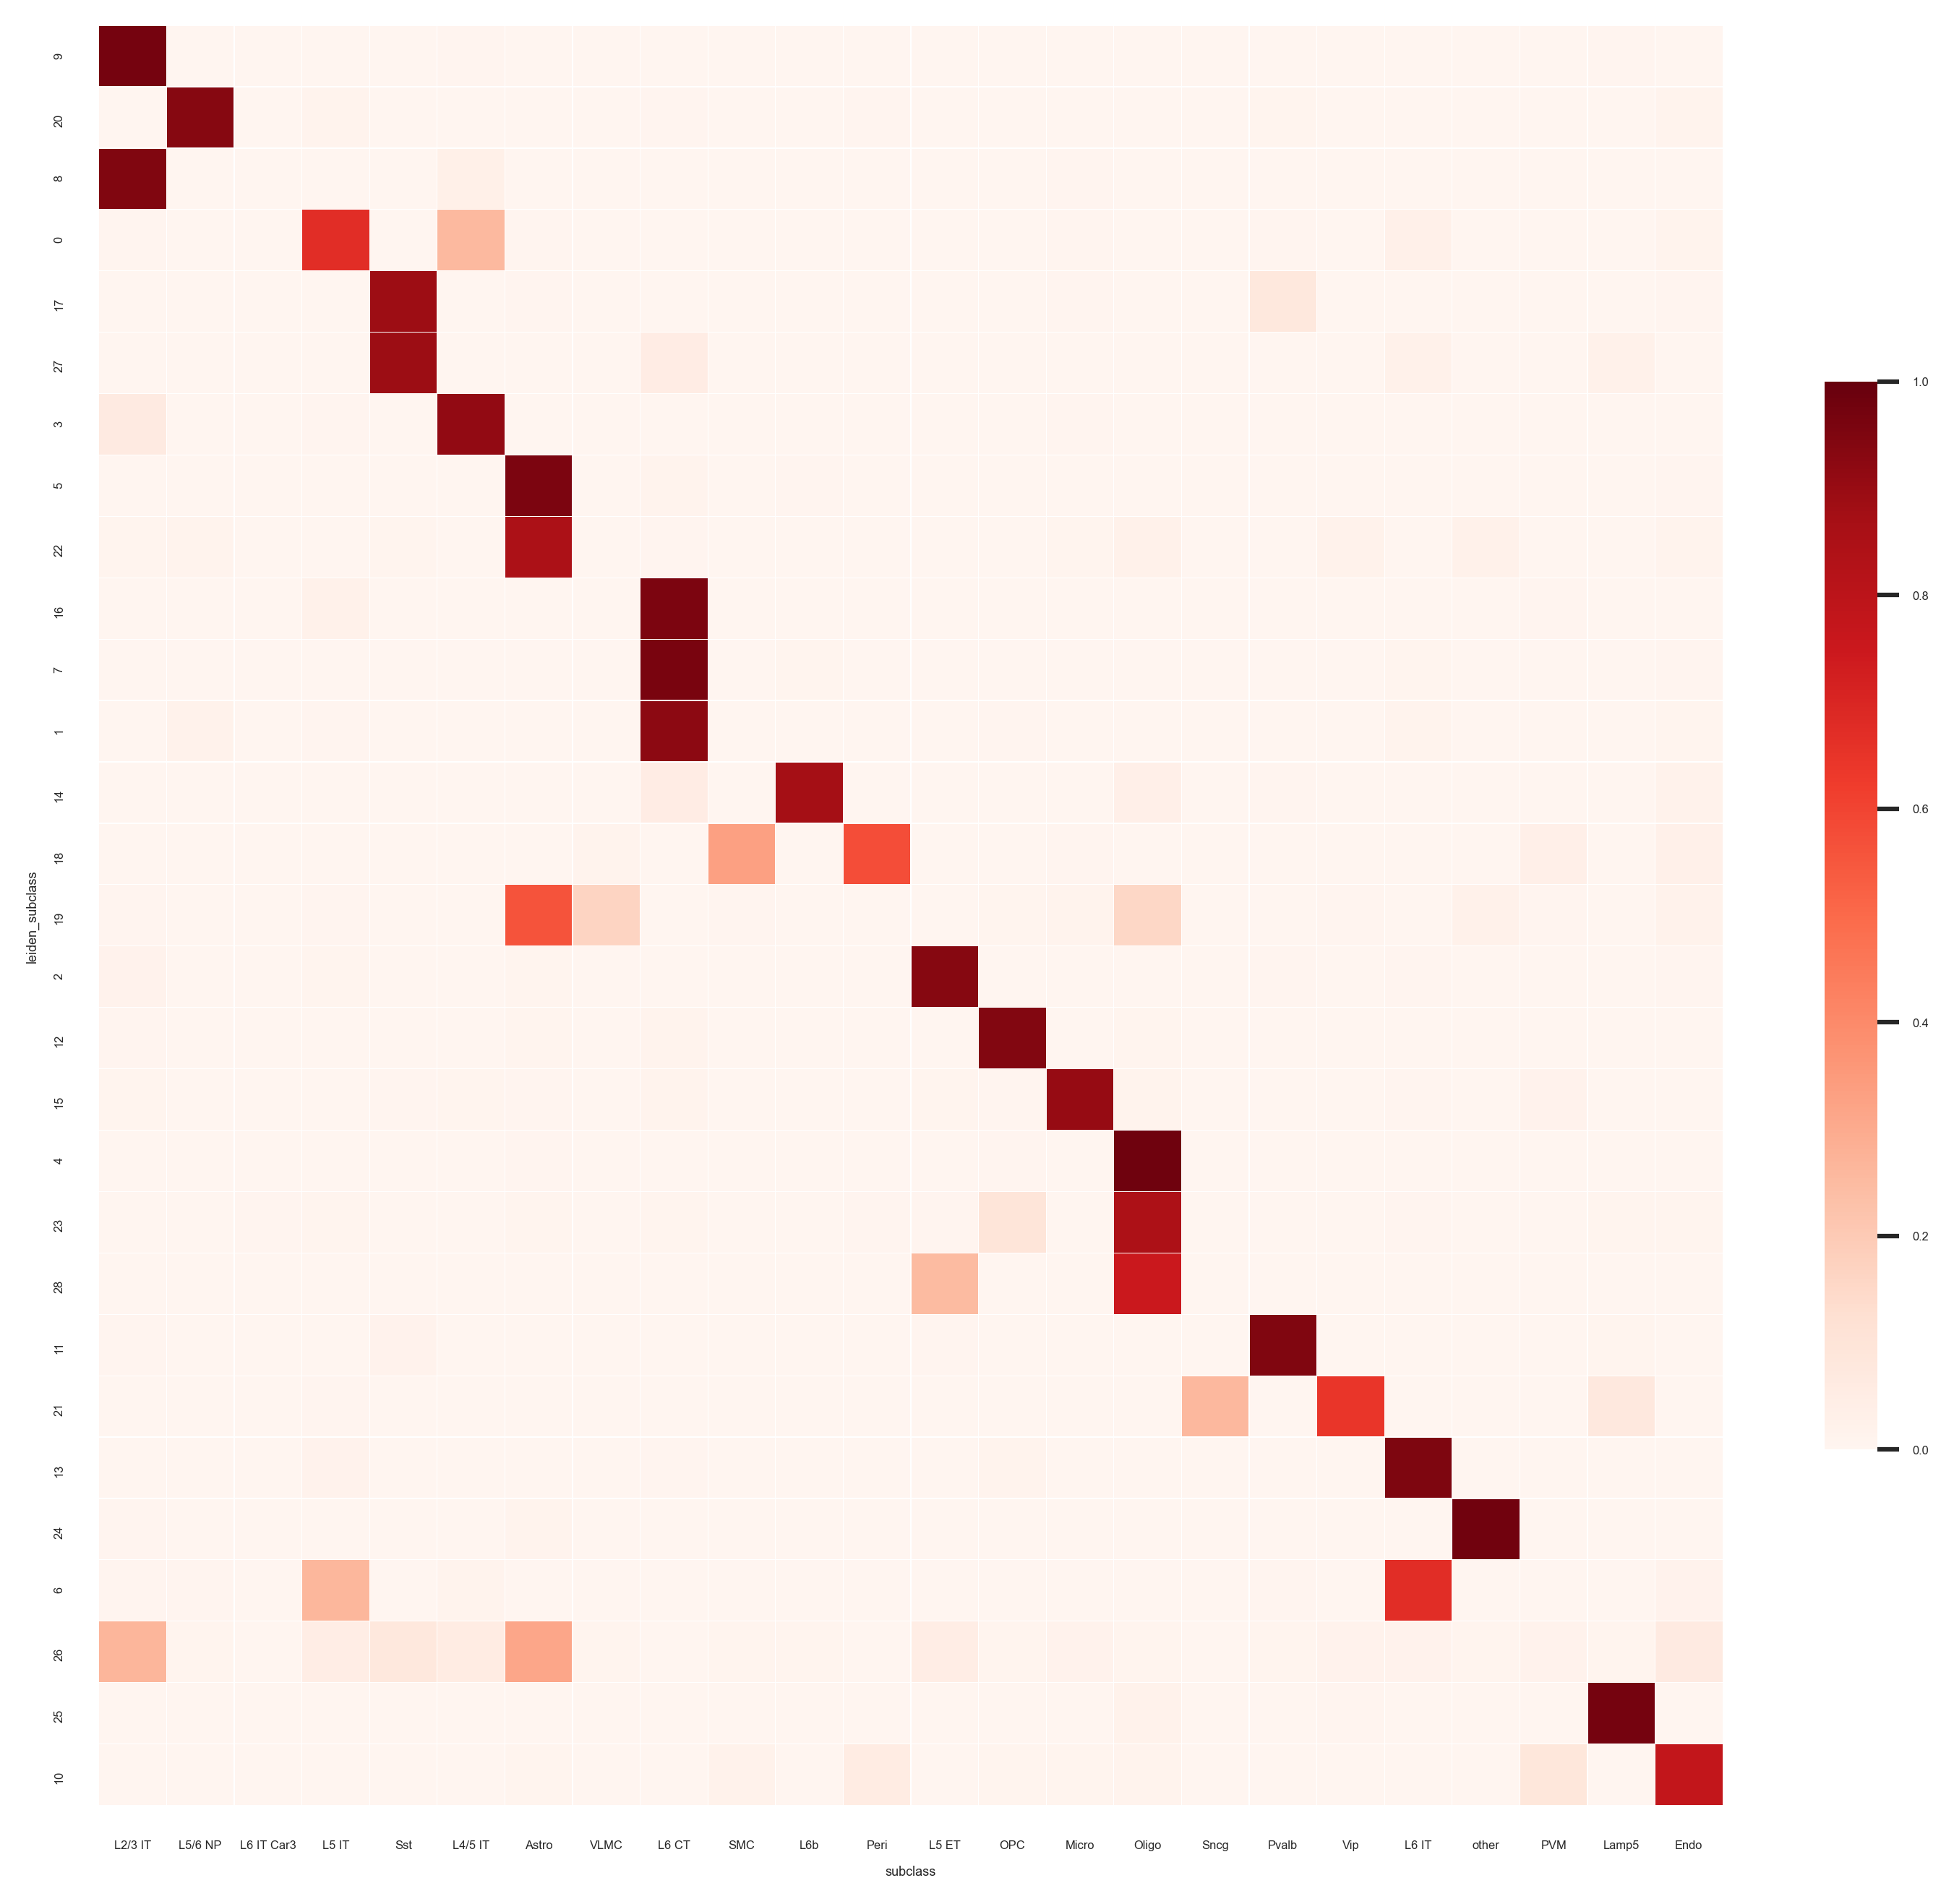

In [308]:

# Define label columns below

# label  column that will be generated in adata_query for prediction result
prediction_column = 'ref_cluster_column'
# label  column in adata_ref to be trained
ref_cluster_column = 'subclass'
# label  column in adata_query to be predicted 
query_cluster_column = 'leiden_subclass'


# Predict cell types using the MLP Classifier above
print('Predict cell types.')
predict_classes(nnc, adata_query, prediction_column, genes)
    
# Count predictions and run permutation and plot
prediction_counts = adata_query.obs[[query_cluster_column, prediction_column]]
prediction_counts['count'] = 1
    
predictionMatrix = pd.pivot_table(prediction_counts, index=[query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)

predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    
fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
#fractions_sorted, rows, columns = runPermutation(fractions,'Columns')
fractions_sorted, rows, columns = runPermutation(fractions,'Both')
    
# Plot
fig1=plt.figure(figsize = (10,9))
sns.set(font_scale=0.3)
#sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
sns.heatmap(fractions_sorted, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
plt.xlabel(ref_cluster_column) 
plt.ylabel(query_cluster_column)
plt.show()

In [346]:
# label  column that is generated in adata_query for prediction result
adata_query.obs['ref_cluster_column']

Unnamed: 0
103330822042850904545146152121560032943    L5 ET
104063594401945690395360274842267295495    L6 CT
104258342410009895929559247312985567503      Vip
104918479368639330347571169891166551407    L5 ET
107930258087179212316276640499012396013    L6 CT
                                           ...  
62404979957498828768934697084130207956     Astro
63726610533314430357332892254603092389     other
71463130736397350506214027498827904691     other
84488377012712053662454730075346329945     Oligo
90200713300164731928049160856257562345     Oligo
Name: ref_cluster_column, Length: 16465, dtype: object

## 4. Modify the plot by re-sorting the x-y axis

In [309]:
# Get all subclass from adata_ref (Meng)

np.unique(adata_ref['subclass'])

array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Micro', 'OPC',
       'Oligo', 'PVM', 'Peri', 'Pvalb', 'SMC', 'Sncg', 'Sst', 'VLMC',
       'Vip', 'other'], dtype=object)

In [310]:
# Sort all subclass from adata_ref (Meng) as desired; eg.as below

sorted_predicted_labels = ['Lamp5','Sncg','Vip','Sst','Pvalb','L2/3 IT','L4/5 IT','L5 IT',
                          'L6 IT','L6 IT Car3','L5 ET','L5/6 NP','L6 CT','L6b','Astro','OPC','Oligo','Endo','VLMC','SMC','Peri',
                         'Micro','PVM','other']

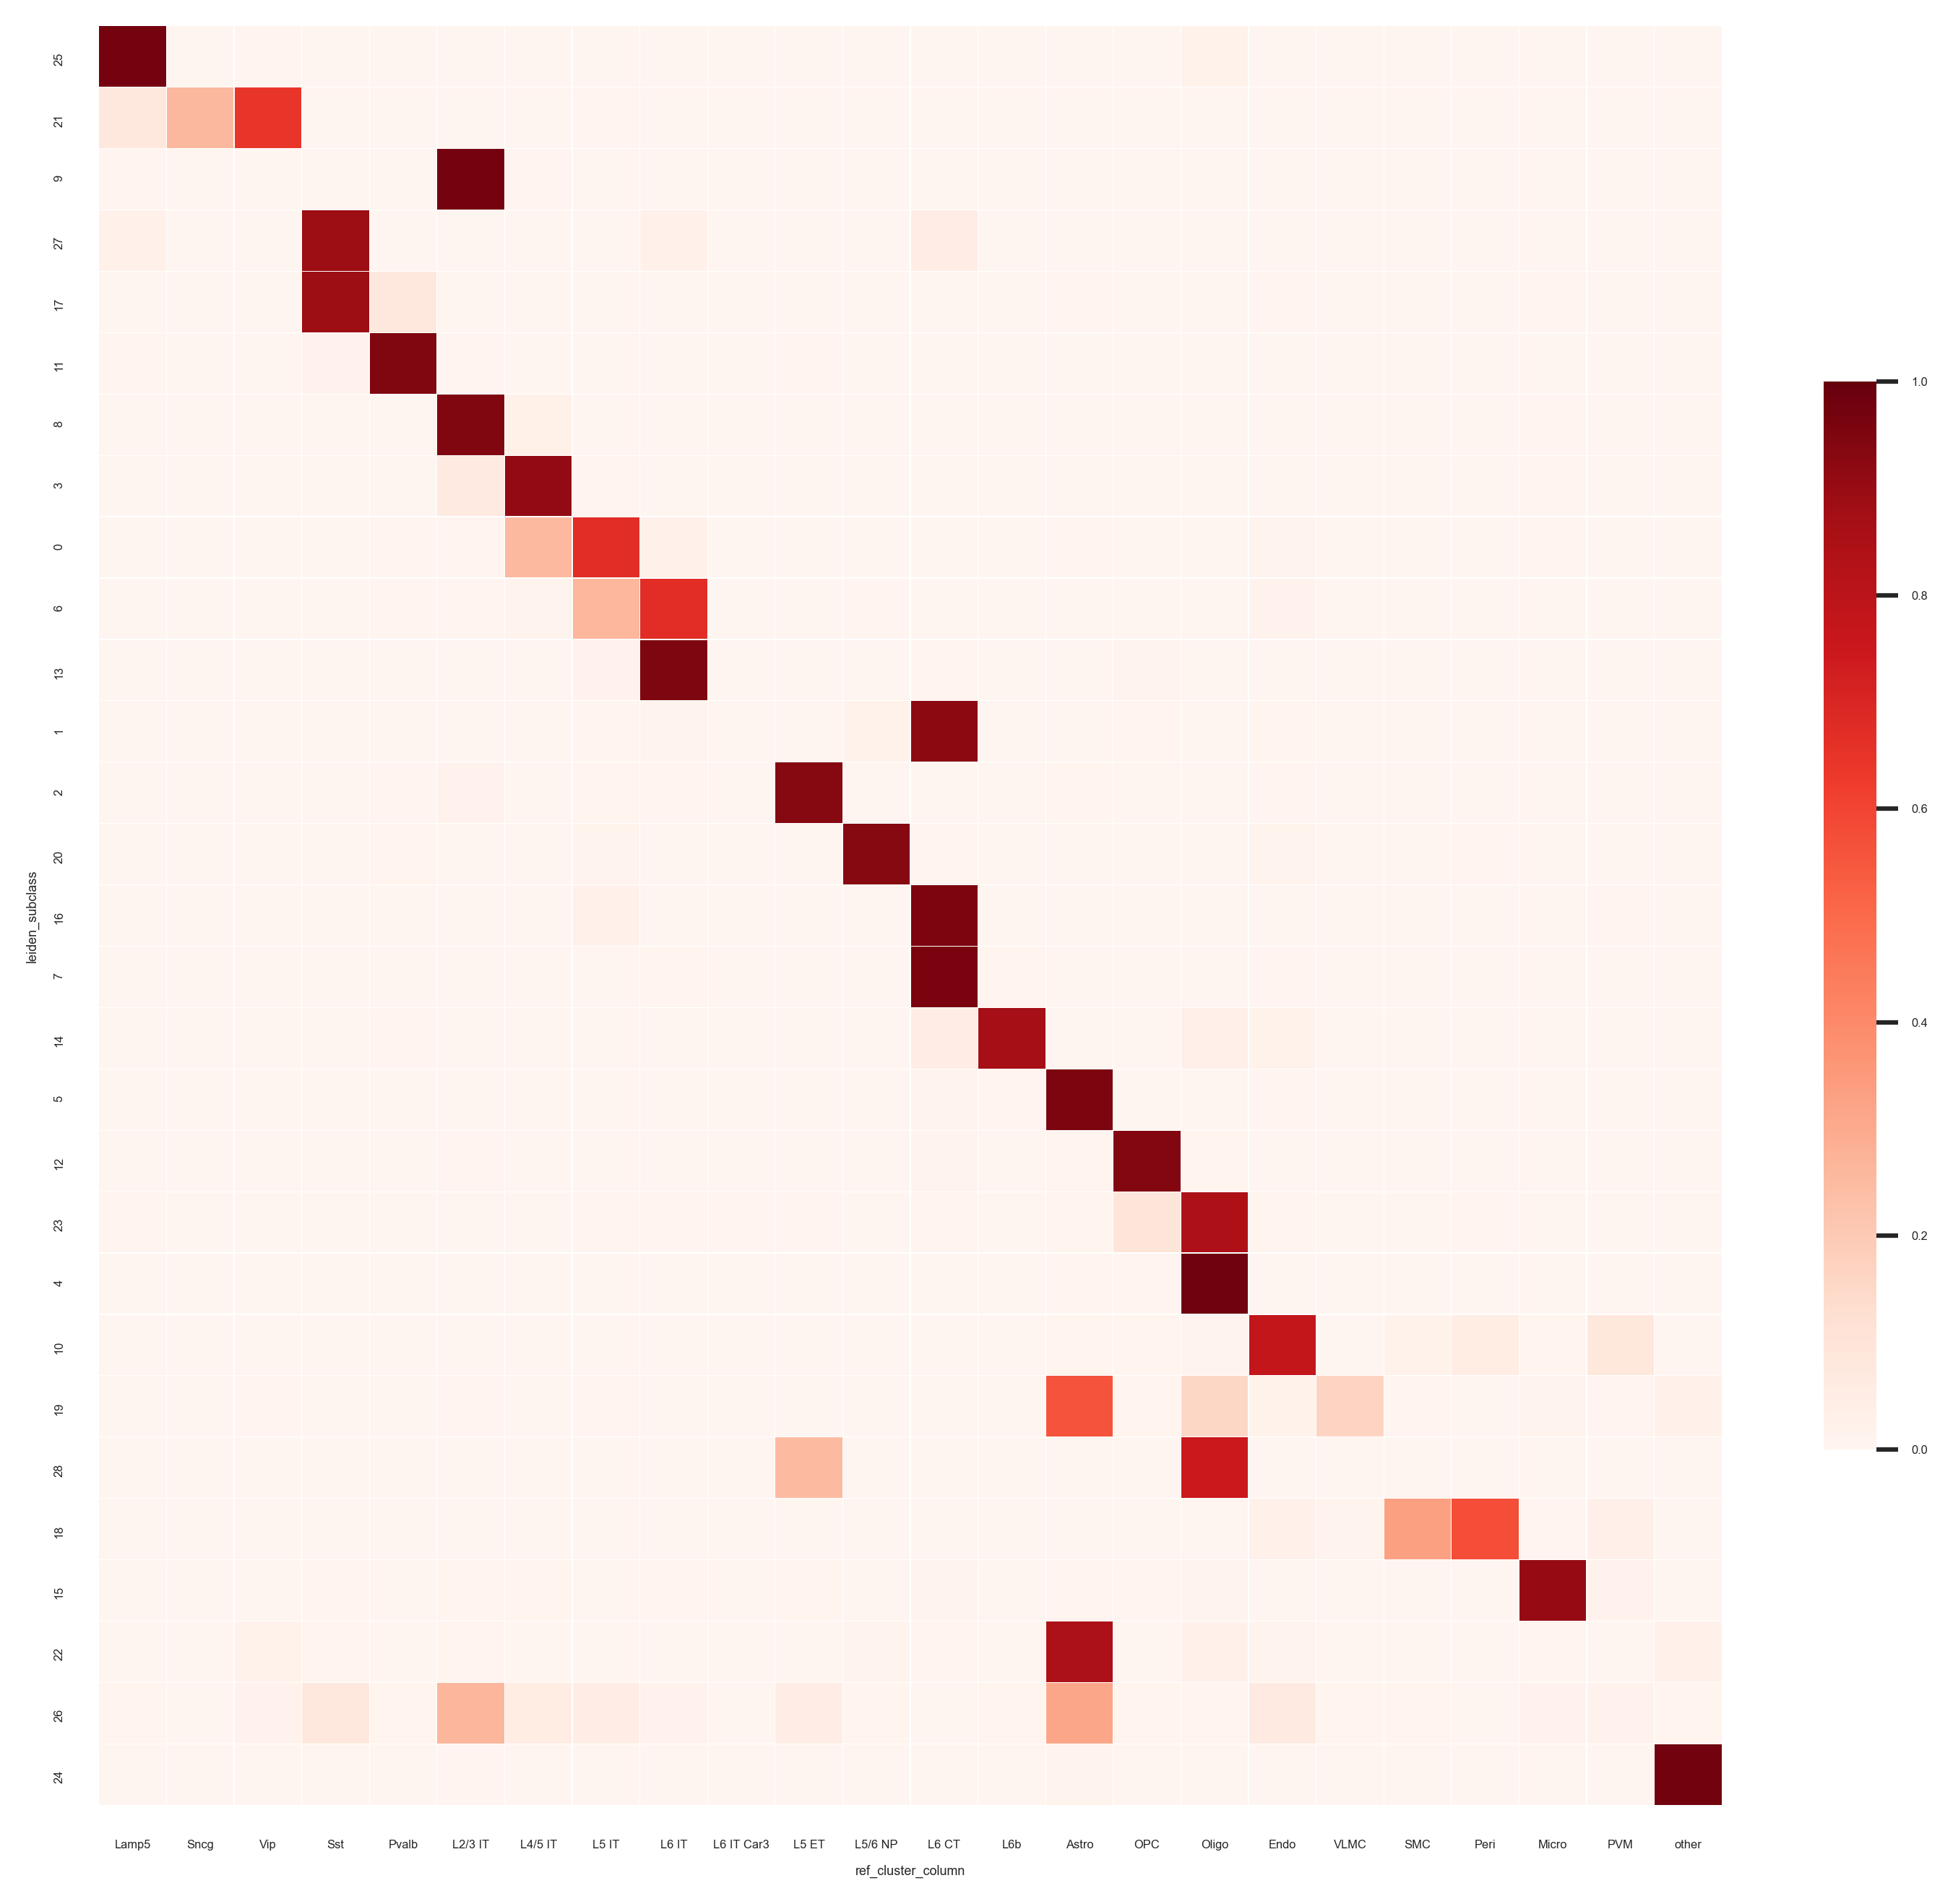

In [311]:
# Re-plot the correspondance plot using the sorted subclass labels


fractions_sorted_by_label = fractions_sorted[sorted_predicted_labels]

sorted_coor_df, rows, columns = runPermutation(fractions_sorted_by_label,'Rows',maxIter = 100,maxTrys = 15)

manual_coor_df = sorted_coor_df


_plot = True
if _plot:
   # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(manual_coor_df, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
    #plt.xlabel(sorted_coor_df.columns) 
    #plt.ylabel(sorted_coor_df.index)
    plt.show()

In [312]:
# Get the current index order
sorted_coor_df.index

CategoricalIndex(['25', '21', '9', '27', '17', '11', '8', '3', '0', '6', '13',
                  '1', '2', '20', '16', '7', '14', '5', '12', '23', '4', '10',
                  '19', '28', '18', '15', '22', '26', '24'],
                 categories=['0', '1', '2', '3', '4', '5', '6', '7', ...], ordered=False, name='leiden_subclass', dtype='category')

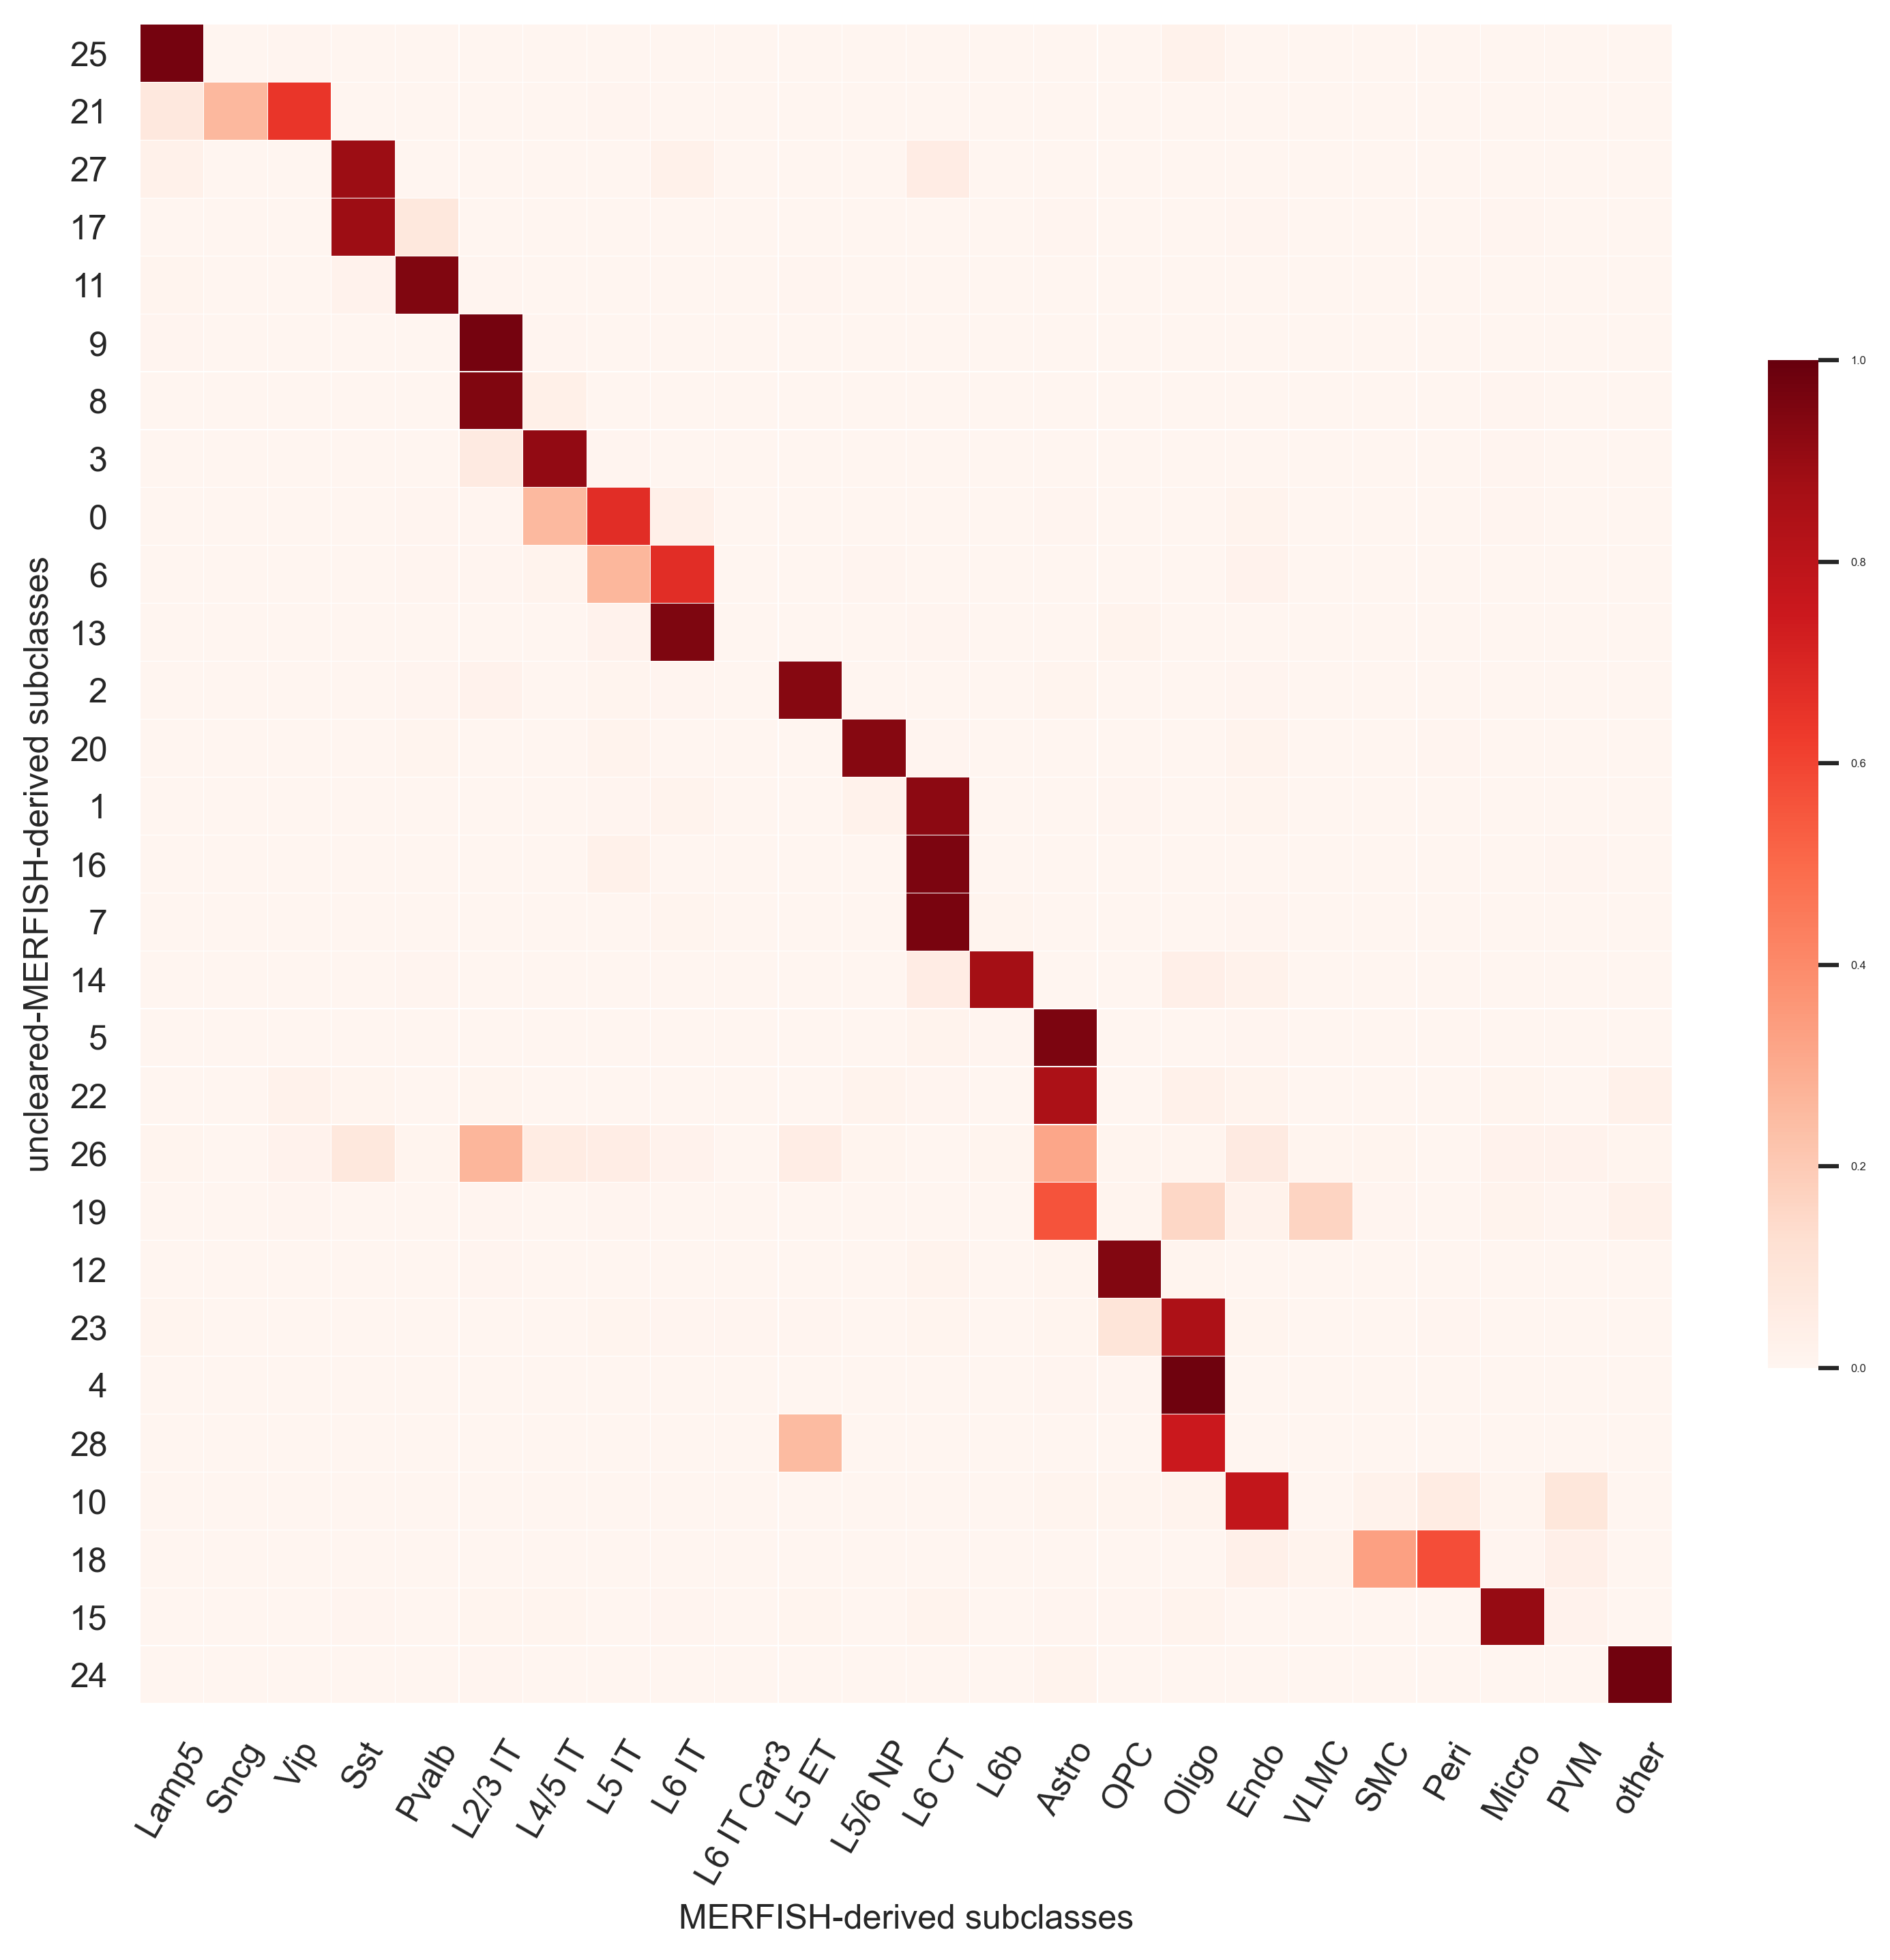

In [314]:
# Re-plot the correspondance plot using the sorted index as desired

manual_coor_df = sorted_coor_df.reindex(['25', '21', '27', '17', '11','9',  '8', '3', '0', '6', '13',
                   '2', '20', '1','16', '7', '14', '5','22','26','19',  '12', '23', '4','28', '10',
                    '18', '15',  '24'])


if _plot:
   # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(manual_coor_df, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
    plt.xlabel('MERFISH-derived subclasses',fontsize=10)
    plt.ylabel('uncleared-MERFISH-derived subclasses',fontsize=10)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.xticks(rotation = 60)
    plt.yticks(rotation = 'horizontal')
    plt.show()